# Parsing the trace files

In [6]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.filterwarnings('ignore')

TIME_FMT = "%Y/%m/%d %H:%M"
TIME_FMT2 = "%Y-%m-%d %H:%M:%S"
TIME_FMT3 = "%Y-%m-%dT%H:%M:%S"
BASETIME = pd.to_datetime("1970-01-01 00:00:00")

philly_trace = "philly/trace-data/cluster_job_log"
helios_base = "helios/data/"
alibaba_v2020_base = "alibaba/cluster-trace-gpu-v2020/data/"
alibaba_v2023_trace = "alibaba/cluster-trace-gpu-v2023/csv/openb_pod_list_default.csv"
acme_base = "acme/data/job_trace"
crux_base = "crux/data"
supercloud_trace = "supercloud/slurm-log.csv"
bluewaters_base = "bluewaters/2019"

# Top-level mapping to per-trace dataframes.
# When parsing, make sure to populate the common fields:
# arrival, arrival_dt, jct, running, queueing, gpu...
traces = {
    'bluewaters 2019': None,
    'philly 2019': None,
    'alibaba 2020': None,
    'helios 2021': None,
    'supercloud 2021': None,
    'alibaba 2023': None,
    'acme 2024': None,
    'crux 2024': None,
}

# Total number of GPUs in the cluster (numbers derived from publication).
cluster_capacity = {
    'bluewaters 2019': 4228,
    'philly 2019': 2490,
    'alibaba 2020': 6742,
    'helios 2021': 6856,
    'supercloud 2021': 448,
    'alibaba 2023': 6212,
    'acme 2024': 4704,
    'crux 2024': 2000,
}

## Bluewaters trace

In [7]:
def parse_log(log_file):
    parsed_records = []
    with open(log_file, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if not line:
                continue
            if "Resource_List.nodes" not in line:
                continue
            if "xk" not in line:
                continue

            # Split the line into the main parts and the attributes string
            parts = line.split(";", 3)
            # Basic info
            record = {}
            if parts[1] != "E":
                continue
            # If there are key=value attributes, parse them
            if len(parts) > 3:
                attributes = parts[3].split(" ")
                for attr in attributes:
                    # Split only on the first '=' to handle values that might contain it
                    kv = attr.split("=", 1)
                    if len(kv) == 2:
                        key, value = kv
                        if key.startswith("Resource_List.nodes"):
                            record["gpu"] = int(value.split(":")[0])
                        if key in ["qtime", "start", "end"]:
                            record[key] = int(value)

            if not record:
                continue
            parsed_records.append(record)
    return parsed_records


all_records = []
for root, dirs, files in os.walk(bluewaters_base):
    for file in files:
        file_path = os.path.join(root, file)
        with open(file_path, "r") as f:
            records = parse_log(file_path)
            all_records.extend(records)


# Create the DataFrame
df = pd.DataFrame(all_records)
df['arrival_dt'] = pd.to_datetime(df['qtime'], unit='s')
df['running'] = df['end'] - df['start']
df['queueing'] = df['start'] - df['qtime']
df['jct'] = df['queueing'] + df['running']
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
traces['bluewaters 2019'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['bluewaters 2019'].head(10))

        qtime       start  gpu         end          arrival_dt  running  \
0  1544046589  1546297065   12  1546354910 2018-12-05 21:49:49    57845   
1  1544046591  1546355023   12  1546413211 2018-12-05 21:49:51    58188   
2  1544046593  1546413281   12  1546471228 2018-12-05 21:49:53    57947   
3  1544046595  1546471304   12  1546528415 2018-12-05 21:49:55    57111   
4  1544046597  1546528476   12  1546586274 2018-12-05 21:49:57    57798   
5  1544046598  1546586524   12  1546644214 2018-12-05 21:49:58    57690   
6  1544046600  1546644389   12  1546705948 2018-12-05 21:50:00    61559   
7  1544046602  1546706091   12  1546770592 2018-12-05 21:50:02    64501   
8  1544046605  1546770649   12  1546840764 2018-12-05 21:50:05    70115   
9  1544046607  1546840905   12  1546898508 2018-12-05 21:50:07    57603   

   queueing      jct  arrival  
0   2250476  2308321      0.0  
1   2308432  2366620      2.0  
2   2366688  2424635      4.0  
3   2424709  2481820      6.0  
4   2481879  2

## Philly [ATC'19] trace

In [8]:
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.strptime(date_str, DATE_FORMAT_STR)

class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = (self._attempts[-1]['end_time'] -
                                      self._attempts[0]['start_time']).total_seconds()
                self._queueing_delay = (self._attempts[0]['start_time'] -
                                        self._submitted_time).total_seconds()
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

with open(philly_trace, 'r') as f:
    cluster_job_log = json.load(f)

jobs = []
for i, j in enumerate(cluster_job_log):
    job = Job(**j)
    if not job.queueing_delay or not job.run_time:
        continue
    # job.run_time does not include queueing delay.
    jobs.append({'jobid': job.jobid, 'status': job.status,
                 'gpu': job.num_gpus,
                 'submitted_time': job.submitted_time,
                 'queueing': job.queueing_delay,
                 'running': job.run_time,
                 'jct': job.run_time + job.queueing_delay
                })
df = pd.DataFrame(jobs)
df['arrival_dt'] = pd.to_datetime(df['submitted_time'], format=TIME_FMT2)
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
traces['philly 2019'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['philly 2019'].head(10))

                             jobid  status  gpu      submitted_time  \
0  application_1501012364013_16024  Killed    1 2017-08-14 23:27:00   
1  application_1501012364013_19938  Killed    1 2017-08-18 01:29:43   
2  application_1501012364013_19939  Killed    1 2017-08-18 01:29:44   
3  application_1501012364013_19940  Killed    1 2017-08-18 01:29:46   
4  application_1501012364013_20139  Killed    1 2017-08-18 07:46:45   
5  application_1501012364013_20168  Killed    1 2017-08-18 08:01:30   
6  application_1501012364013_20176  Killed    1 2017-08-18 08:31:36   
7  application_1501012364013_21310  Killed    1 2017-08-18 21:20:18   
8  application_1501012364013_21984  Killed    8 2017-08-21 05:21:52   
9  application_1501012364013_23793  Killed    4 2017-08-24 02:00:28   

    queueing    running        jct          arrival_dt   arrival  
0  1570682.0  3613033.0  5183715.0 2017-08-14 23:27:00       0.0  
1  1304119.0  3222990.0  4527109.0 2017-08-18 01:29:43  266563.0  
2  1304118.0  387

## Helios [SC'21] trace

In [9]:
dfs = []
for name in ['Earth', 'Saturn', 'Uranus', 'Venus']:
    trace_name = helios_base + name + '/cluster_log.csv'
    df = pd.read_csv(trace_name)
    df['cluster_name'] = name
    df['cpu'] = df['cpu_num']
    df['gpu'] = df['gpu_num']
    df = df.drop(columns=['cpu_num', 'gpu_num'])
    df['arrival_dt'] = pd.to_datetime(df['submit_time'], format=TIME_FMT2)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['duration']) | \
                pd.isna(df['queue'])].index)
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
df['queueing'] = df['queue']
df['running'] = df['duration']
# Duration does not include queueing delay.
df['jct'] = df['duration'] + df['queueing']
# Filter out the non-positive duration. NB: queueing delay can be zero.
df = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index)

traces['helios 2021'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['helios 2021'].head(10))

    job_id   user     vc  node_num      state          submit_time  \
0   363167  u1Eem  vccJW         4    TIMEOUT  2020-03-18 04:01:39   
1  2921826  uYlPU  vcSE7         1    TIMEOUT  2020-03-18 14:21:22   
2  2922917  u9jR8  vcdoX         1    TIMEOUT  2020-03-18 17:31:00   
3  2934117  uH3om  vcOIr         1    TIMEOUT  2020-03-19 10:16:49   
4  2934215  uYlPU  vcSE7         1    TIMEOUT  2020-03-19 11:01:28   
5  2934386  u90Bq  vcSE7         1    TIMEOUT  2020-03-19 11:36:06   
6    76723  uMyhN  vcgkz         1  COMPLETED  2020-03-20 16:06:15   
7  2940006  uyg4r  vcQ4H         1    TIMEOUT  2020-03-20 16:48:37   
8  1380066  uVCWx  vcrV2         1    TIMEOUT  2020-03-22 10:38:56   
9  1381347  ulqKP  vcG8f         1  CANCELLED  2020-03-23 01:25:21   

            start_time             end_time  duration  queue cluster_name  \
0  2020-03-18 04:01:39  2020-04-01 04:01:54   1209615      0        Venus   
1  2020-03-18 14:21:22  2020-04-01 14:21:45   1209623      0       Saturn  

## MIT supercloud [HPEC'21] trace

In [10]:
def find_alloc_matches(text):
  # Split the string and keep only the GPU usage part. (1001 and 1002 are GPU resource types)
  return [int(s.split('=')[1]) for s in text.split(',') if s.startswith('1001=') or s.startswith('1002=')][0]

df = pd.read_csv(supercloud_trace)
df['arrival_dt'] = pd.to_datetime(df['time_submit'], unit='s')
df['running'] = df['time_end'] - df['time_start']
df['queueing'] = df['time_start'] - df['time_submit']
df['jct'] = df['running'] + df['queueing']
df = df[df['tres_alloc'].str.contains('1001|1002', na=False)]
df['gpu'] = df['tres_alloc'].apply(find_alloc_matches)
df = df[['arrival_dt', 'running', 'queueing', 'jct', 'gpu']]

df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
traces['supercloud 2021'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['supercloud 2021'].head(10))

           arrival_dt  running  queueing     jct  gpu   arrival
0 2021-02-05 21:35:15      463         0     463    1       0.0
1 2021-02-08 18:40:06      703     46721   47424    1  248691.0
2 2021-02-08 18:49:58      857         1     858    1  249283.0
3 2021-02-08 20:57:27    32436      4474   36910    2  256932.0
4 2021-02-08 22:41:49   177301       676  177977    1  263194.0
5 2021-02-08 23:23:42      870     28138   29008    1  265707.0
6 2021-02-08 23:23:46      903     11765   12668    1  265711.0
7 2021-02-08 23:25:17     1303     11747   13050    1  265802.0
8 2021-02-09 03:01:52      650      3007    3657    1  278797.0
9 2021-02-09 03:01:52     2947        59    3006    1  278797.0


## Alibaba 2020 [NSDI'22] trace

In [11]:
dfj = pd.read_csv(alibaba_v2020_base + 'pai_job_table.csv', header=None, names=['job_name', 'inst_id', 'user', 'status', 'start_time', 'end_time'])
dft = pd.read_csv(alibaba_v2020_base + 'pai_task_table.csv', header=None, names=['job_name', 'task_name', 'inst_num', 'status', 'start_time',
                                                                                 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type'])
# Many tasks are under the same job name. Merge them into one record and keep the latest start/end times.
dft = dft.groupby('job_name').agg({'start_time': 'max', 'end_time': 'max', 'plan_cpu': 'sum', 'plan_gpu': 'sum'}).reset_index()
df = dfj.merge(dft, on=['job_name'], how='left', suffixes = ['','_task'])
df['cpu'] = df['plan_cpu'] / 100
df['gpu'] = df['plan_gpu'] / 100
df = df.drop(columns=['plan_cpu', 'plan_gpu'])
df = df.dropna(subset=['start_time', 'end_time', 'start_time_task', 'end_time_task'])
df['arrival_dt'] = df['start_time'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
df['queueing'] = df['start_time_task'] - df ['start_time']
df['running'] = df['end_time'] - df['start_time_task']
df['jct'] = df['end_time'] - df ['start_time']
traces['alibaba 2020'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['alibaba 2020'].head(10))

                   job_name  \
0  193e6fdd5cb271f54d85f739   
1  231efd68de94779ed7b9aff6   
2  4d70a8930e415447fba17963   
3  96e053818c246cd68f301d40   
4  2883edbad23c6bef16f655c0   
5  895a99e58c36991c59509917   
6  b70720e730934ea003a83b42   
7  3e6f005d5fc08a0108f4eb1e   
8  7d90cacc27d735d9b3f024c2   
9  10e530eb422cec7bb19c6fd7   

                                             inst_id          user  \
0  b150d2eccab57c9539f8ba1c3804c37e5532e681dc7d0a...  74238accb90b   
1  e55465e9e26523cdeba168087a050aa950ac723bd7532e...  74238accb90b   
2  6f7d426945058a53111cc686c0fd5df2afb2ba017d0544...  74238accb90b   
3  5327aa4ce5fb0578f93779cab2b45bb6806c2b3d11ac3c...  74238accb90b   
4  8f26613dc5591cf8ab57f7abd4d37221bee5d3701443c1...  74238accb90b   
5  805b276d3a3328c425aca1f6633796411f1cd6df95e888...  74238accb90b   
6  4ef18d566fea077d8ebf1dcc9e04656601467d911560c5...  74238accb90b   
7  6cdf1f7137c6b942493ccce28221e6ef983311c96eaaf5...  74238accb90b   
8  478e9b8bf174778b7fe5815a5

## Alibaba 2023 [ATC'23] trace

In [12]:
df = pd.read_csv(alibaba_v2023_trace)
df['cpu'] = df['cpu_milli'] / 1000
df['gpu'] = df['num_gpu']
df = df.drop(columns=['cpu_milli', 'num_gpu'])
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['creation_time']) | \
                pd.isna(df['deletion_time']) | \
                pd.isna(df['scheduled_time'])].index)
df['arrival_dt'] = df['creation_time'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
# Diff the timestamps to get queueing and jct.
df['queueing'] = df['scheduled_time'] - df['creation_time']
df['running'] = df['deletion_time'] - df['scheduled_time']
df['jct'] = df['deletion_time'] - df['creation_time']
# Filter out the non-positive duration. NB: queueing delay can be zero.
traces['alibaba 2023'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['alibaba 2023'].head(10))

             name  memory_mib  gpu_milli  gpu_spec qos pod_phase  \
0  openb-pod-0000       16384       1000       NaN  LS   Running   
1  openb-pod-0001       12288        460       NaN  LS   Running   
2  openb-pod-0002       24576       1000       NaN  LS   Running   
3  openb-pod-0003       12288        460       NaN  LS   Running   
4  openb-pod-0004       16384       1000       NaN  LS   Running   
5  openb-pod-0005       65536          0       NaN  LS   Running   
6  openb-pod-0006       16384       1000       NaN  LS   Running   
7  openb-pod-0007       16384       1000       NaN  LS   Running   
8  openb-pod-0008       16384       1000       NaN  LS   Running   
9  openb-pod-0009       16384       1000       NaN  LS   Running   

   creation_time  deletion_time  scheduled_time   cpu  gpu  \
0              0       12537496             0.0  12.0    1   
1         427061       12902960        427061.0   6.0    1   
2        1558381       12902960       1558381.0  12.0    1   
3  

## Acme [NSDI'24] trace

In [13]:
dfs = []
for cluster in ['kalos', 'seren']:
    trace_name = f'{acme_base}/trace_{cluster}.csv'
    df = pd.read_csv(trace_name)
    if cluster == 'kalos':
        # Drop columns not in the seren trace so that they can be concatenated.
        df = df[df.columns.drop(list(df.filter(regex='mem_per_pod_GB') &
                                     df.filter(regex='shared_mem_per_pod') &
                                     df.filter(regex='fail_time') &
                                     df.filter(regex='stop_time')
                                    ))]
    df['cluster_name'] = cluster
    df['cpu'] = df['cpu_num']
    df['gpu'] = df['gpu_num']
    df = df.drop(columns=['cpu_num', 'gpu_num'])
    tmp = pd.to_datetime(df['submit_time'])
    df['arrival'] = (tmp - tmp.min()).apply(lambda x: x.total_seconds())
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
# Rebuild a uniform (fake) arrival time.
df['arrival_dt'] = df['arrival'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['queueing'] = df['queue']
df['running'] = df['duration']
# Duration does not include queueing delay.
df['jct'] = df['duration'] + df['queue']
# Filter out the non-positive duration. NB: queueing delay can be zero.
df = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index)
traces['acme 2024'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['acme 2024'].head(10))

             job_id   user  node_num   type      state  \
0  dlctk696s0jbvitv  uf794         8  Other     FAILED   
1           5778432  u5907         1  Other     FAILED   
2           5778469  u5907         1  Other  COMPLETED   
3  dlcgiwd1g3i1cfgl  uf794         8  Other     FAILED   
4           5778565  u8742         1  Other     FAILED   
5  dlc1t2ypl09b8qtp  uf794         8  Other  CANCELLED   
6  dlcj0vimc1r8uc4f  uf794         8  Other  COMPLETED   
7           5778592  ud035         2  Other     FAILED   
8           5778612  ud035         4  Other  COMPLETED   
9  dlcyu9s048ourmoe  uf794         8  Other  COMPLETED   

                 submit_time                 start_time  \
0  2023-05-17 11:00:58+00:00  2023-05-17 11:01:08+00:00   
1  2023-03-01 00:18:22+08:00  2023-03-01 00:18:54+08:00   
2  2023-03-01 00:23:58+08:00  2023-03-01 00:24:11+08:00   
3  2023-05-17 11:21:32+00:00  2023-05-17 11:21:45+00:00   
4  2023-03-01 00:43:51+08:00  2023-03-01 00:43:53+08:00   
5  2023

## Crux [SIGCOMM'24] trace

In [14]:
crux_job = f'{crux_base}/job.csv'
crux_worker = f'{crux_base}/worker.csv'
df = pd.read_csv(crux_job)
# Filter out the irrelevant fields.
df = df[df.columns.drop(list(df.filter(regex='Unnamed') &
                             df.filter(regex='extended') &
                             df.filter(regex='etcd')
                            ))]
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['gmt_job_submitted']) | \
                pd.isna(df['gmt_job_running']) | \
                pd.isna(df['gmt_job_finished'])].index)
# Convert the string format timestamps to datetime objects.
df['gmt_job_submitted'] = pd.to_datetime(df['gmt_job_submitted'], format=TIME_FMT)
df['gmt_job_running'] = pd.to_datetime(df['gmt_job_running'], format=TIME_FMT)
df['gmt_job_finished'] = pd.to_datetime(df['gmt_job_finished'], format=TIME_FMT)
df['arrival_dt'] = df['gmt_job_submitted']
df['arrival'] = (df['gmt_job_submitted'] - df['gmt_job_submitted'].min()).apply(lambda x: x.total_seconds())
# Diff the timestamps to get queueing and jct.
df['queueing'] = (df['gmt_job_running'] - df['gmt_job_submitted']).apply(lambda x: x.total_seconds())
df['running'] = (df['gmt_job_finished'] - df['gmt_job_running']).apply(lambda x: x.total_seconds())
df['jct'] = (df['gmt_job_finished'] - df['gmt_job_submitted']).apply(lambda x: x.total_seconds())
# Filter out the non-positive duration. NB: queueing delay can be zero.
df = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)

dfw = pd.read_csv(crux_worker)
tmp = dfw['RES'].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
columns_to_convert = ['cpu', 'nvidia.com/gpu']
tmp[columns_to_convert] = tmp[columns_to_convert].apply(pd.to_numeric, errors='coerce')
dfw = dfw.join(tmp)
dfw = dfw.drop(columns=['RES'])
# Many workers are under the same job name. Merge them into one record and sum up the GPUs.
dfw = dfw.groupby('job_name').agg({'cpu': 'sum', 'nvidia.com/gpu': 'sum'}).reset_index()
dfw.columns = ['job_name', 'cpu', 'gpu']
df = df.merge(dfw, on=['job_name'], how='left', suffixes = ['','_w'])

traces['crux 2024'] = df
print(traces['crux 2024'].head(10))

      id                                                uid          job_name  \
0  10289  656dd28fa400e4b1a322fbf5996b6d7758212e46e62eca...  dlc1l3ajnoq4jyuw   
1  10290  b6d78abb565b72019a9c54b18a6e60d829efc5efd2ca40...  dlc10arh1gnnexe1   
2  10291  b2b5b26580369d3cd8e4a0704ec5c6178a849ad7ab7b70...  dlctd311gtqeax72   
3  10292  be8150f57c549c644317ea6a40326871d70070f05b0820...  dlcprb478l2ekj3h   
4  10293  c22785ec4f8a7ff3738cc7568e1097e876589a7d0125d6...  dlcqbbpj8g3txdux   
5  10295  a203d0cadc933266c555301063d9305fb6a60b002ac881...  dlc1bei96sdtujoa   
6  10296  9d4db3751fabaac04b132e5cb0f872e1e03fac9d307d4d...  dlc1v3pfd0c8wgui   
7  10297  28acca2a0cdedb622eb4a7bbea8b55bc72d23ecd85344c...  dlc1mg26cgbrtc0l   
8  10298  dcc8e1e77ce40c0d24dd5ceb967ef7bfb32c567e4591bf...  dlcc60mpwfezb94b   
9  10299  7f7882d9f71e9c7d8a18f4133a8a46575ba3abec15e2ec...  dlch5uq6cp3i3agz   

         kind                                          namespace      model  \
0  PyTorchJob  0235e5091b7cb4

# Utils

In [15]:
def trim_trace(df: pd.DataFrame, start: datetime, end: datetime) -> pd.DataFrame:
    """
    Trims a given trace df and only keeps jobs whose arrival time is between start and end.
    """
    if 'arrival_dt' not in df.columns:
        raise ValueError('df has no column named arrival_dt')

    trimmed = df[(df['arrival_dt'] >= start) & (df['arrival_dt'] <= end)]
    return trimmed

def trace_to_iat_dist(df: pd.DataFrame, output: str) -> pd.DataFrame:
    """
    Given a trace, convert it to an inter-arrival time (IAT) distribution.
    Also writes it to a csv file optionally.
    """
    # Drop all other columns.
    iat = df[['arrival']].diff().dropna().reset_index(drop=True)
    iat = iat['arrival'].value_counts(normalize=True).reset_index(drop=False)
    iat.columns = ['# IAT (sec)', 'prob (%)']
    iat['prob (%)'] *= 100
    iat = iat.sort_values(by='# IAT (sec)')
    if output:
        iat.to_csv(output, index=False)
    return iat

# Plots

## JCT/queueing distribution.

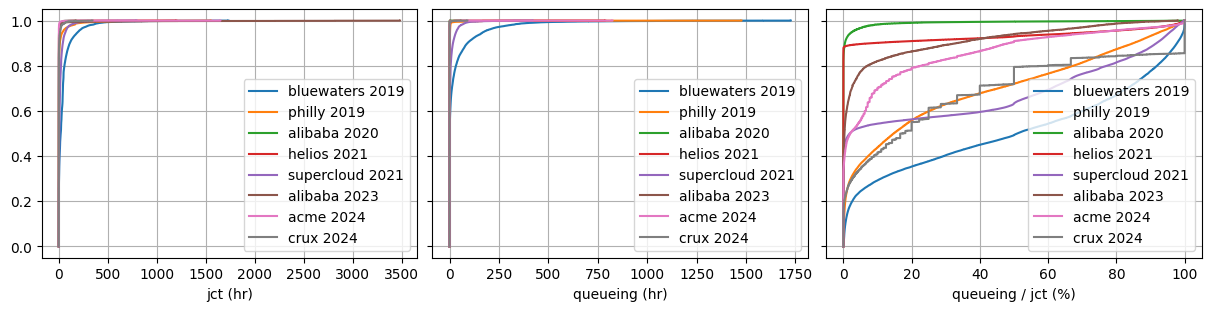

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained", sharey=True)

for i, col in enumerate(['jct', 'queueing', 'ratio']):
    ax = axs[i]
    for name, trace in traces.items():
        if col == 'ratio':
            df = trace['queueing'] / trace['jct'] * 100
        else:
            df = trace[col] / 3600
        ax.ecdf(df, label=name)
    ax.ticklabel_format(style='plain', axis='x')
    label_str = 'queueing / jct (%)' if col == 'ratio' else f'{col} (hr)'
    ax.set_xlabel(label_str)
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    ax.grid()

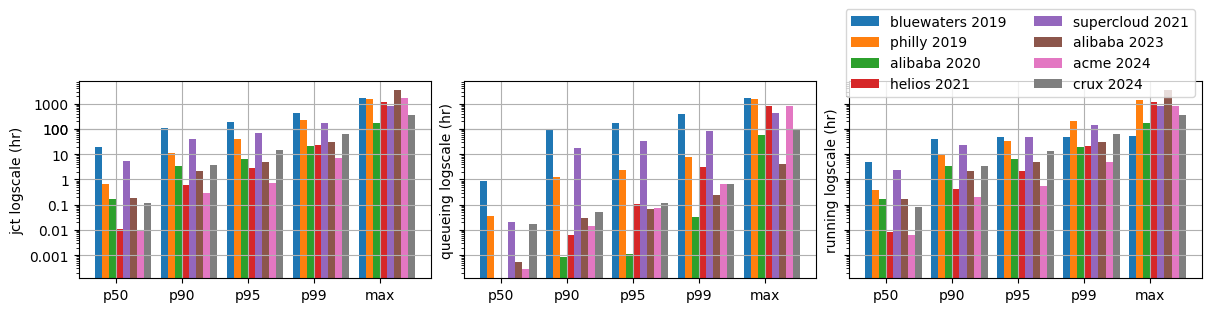

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained", sharey=True)
labels = ['p50', 'p90', 'p95', 'p99', 'max']
width = 0.15
# X locations for the groups
x = np.arange(len(labels)) * 1.4

for i, col in enumerate(['jct', 'queueing', 'running']):
    ax = axs[i]
    for idx, (name, trace) in enumerate(traces.items()):
        df = trace[col] / 3600
        quantiles = [df.quantile(0.5), df.quantile(0.9), df.quantile(0.95), df.quantile(0.99), df.max()]
        # print(f'{name} {col}: {quantiles}')
        # Create side-by-side bar chart
        ax.bar(x + idx * width, quantiles, width=width, label=name)
    ax.set_xticks(x + 2.5 * width, labels)
    ax.set_ylabel(f'{col} logscale (hr)')
    ax.set_yscale('log')
    yticks = [.001, .01, .1, 1, 10, 100, 100, 1000]
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)))
    ax.grid()
ax.legend(ncols=2, loc='upper right', bbox_to_anchor=(1, 1.4))

## inter-arrival time

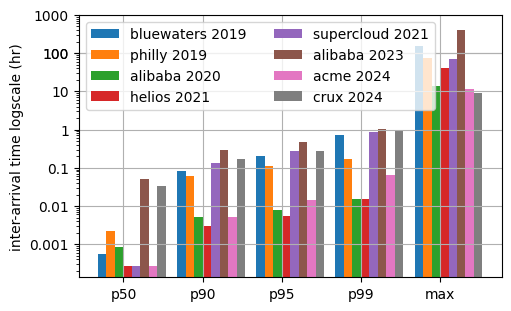

In [18]:
labels = ['p50', 'p90', 'p95', 'p99', 'max']
width = 0.15
# X locations for the groups
x = np.arange(len(labels)) * 1.4

fig, ax = plt.subplots(1, 1, figsize=(5, 3), layout="constrained")
for idx, (name, trace) in enumerate(traces.items()):
    df = trace.sort_values(by='arrival')
    diff = df['arrival'].diff().dropna() / 3600
    quantiles = [diff.quantile(0.5), diff.quantile(0.9), diff.quantile(0.95), diff.quantile(0.99), diff.max()]
    ax.bar(x + idx * width, quantiles, width=width, label=name)
ax.ticklabel_format(style='plain', axis='x')
ax.set_xticks(x + 2.5 * width, labels)
ax.set_ylabel('inter-arrival time logscale (hr)')
ax.set_yscale('log')
yticks = [.001, .01, .1, 1, 10, 100, 100, 1000]
ax.set_yticks(yticks)
ax.set_yticklabels(list(map(str, yticks)))
ax.grid()
ax.legend(ncols=2)

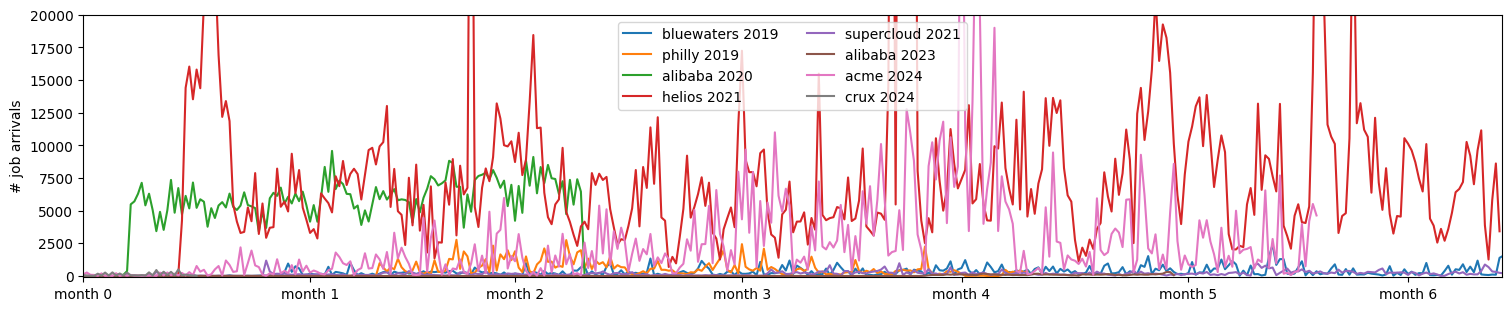

In [19]:
start = pd.to_datetime("1970-01-01 00:00:00")
end = pd.to_datetime("1970-07-13 19:00:00")

fig, ax = plt.subplots(1, 1, figsize=(15, 3), layout="constrained")
for idx, (name, trace) in enumerate(traces.items()):
    # arrival_dt is not aligned across traces, so use arrival for plotting.
    df = trace.sort_values(by='arrival')
    df['ts'] = pd.to_datetime(df['arrival'], unit='s')
    df.set_index('ts', inplace=True)
    # Aggregate window
    window_size = '12H'
    ts = df.resample(window_size).count()
    ax.plot(ts.index, ts['arrival'], label=name)
    # print(name, ts.index.min(), ts.index.max())
ax.set_xlim([start, end])
diff = relativedelta(end, start)
months = [start + relativedelta(months=i) for i in range(diff.years * 12 + diff.months + 1)]
ax.set_xticks(months)
ax.set_xticklabels([f'month {i}' for i in range(len(months))])
ax.set_ylim([-100, 20000])
ax.set_ylabel('# job arrivals')
ax.legend(ncols=2)

## Try to find your favorite bursty (or calm) duration in a trace, and convert that to an IAT distribution. 

     # IAT (sec)  prob (%)
5            0.0  2.071687
12           1.0  1.019402
0            2.0  4.833936
4            3.0  2.236107
2            4.0  2.564946
..           ...       ...
446      23267.0  0.032884
401      27386.0  0.032884
527      27639.0  0.032884
337      27958.0  0.032884
415      30664.0  0.032884

[533 rows x 2 columns]


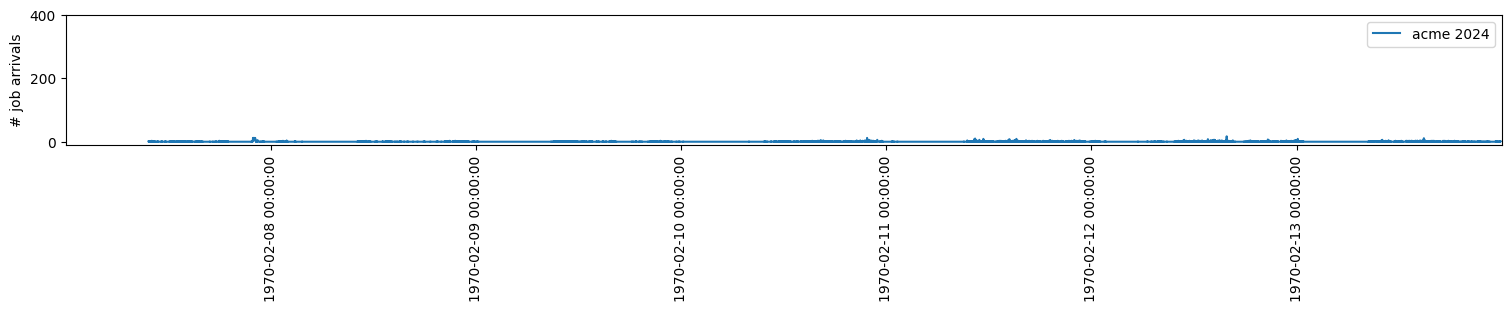

In [20]:
# # This is the burstiest 2-day window in the Helios trace.
# start = pd.to_datetime("2020-07-08 00:00:00")
# end = pd.to_datetime("2020-07-09 17:00:00")

name = 'acme 2024'
trace = traces[name]
trace = trace.drop(trace[trace['cluster_name'] == 'kalos'].index)
# A calm week in Acme trace.
start = pd.to_datetime("1970-02-07 00:00:00")
end = pd.to_datetime("1970-02-14 00:00:00")

fig, ax = plt.subplots(1, 1, figsize=(15, 3), layout="constrained")
df = trim_trace(trace, start, end)
df.set_index('arrival_dt', inplace=True)
# Aggregate window
window_size = '60S'
ts = df.resample(window_size).count()
ax.plot(ts.index, ts['arrival'], label=name)
# print(name, ts.index.min(), ts.index.max())
ax.set_xlim([start, end])
ticks = []
t = start
while t + relativedelta(days=1) < end:
    t += relativedelta(days=1)
    ticks.append(t)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=90)
ax.set_ylim([-10, 400])
ax.set_ylabel('# job arrivals')
ax.legend(ncols=2)

output = None
trimmed = trim_trace(trace, start, end)
iat = trace_to_iat_dist(trimmed, output)
print(iat)

## Job size and queueing

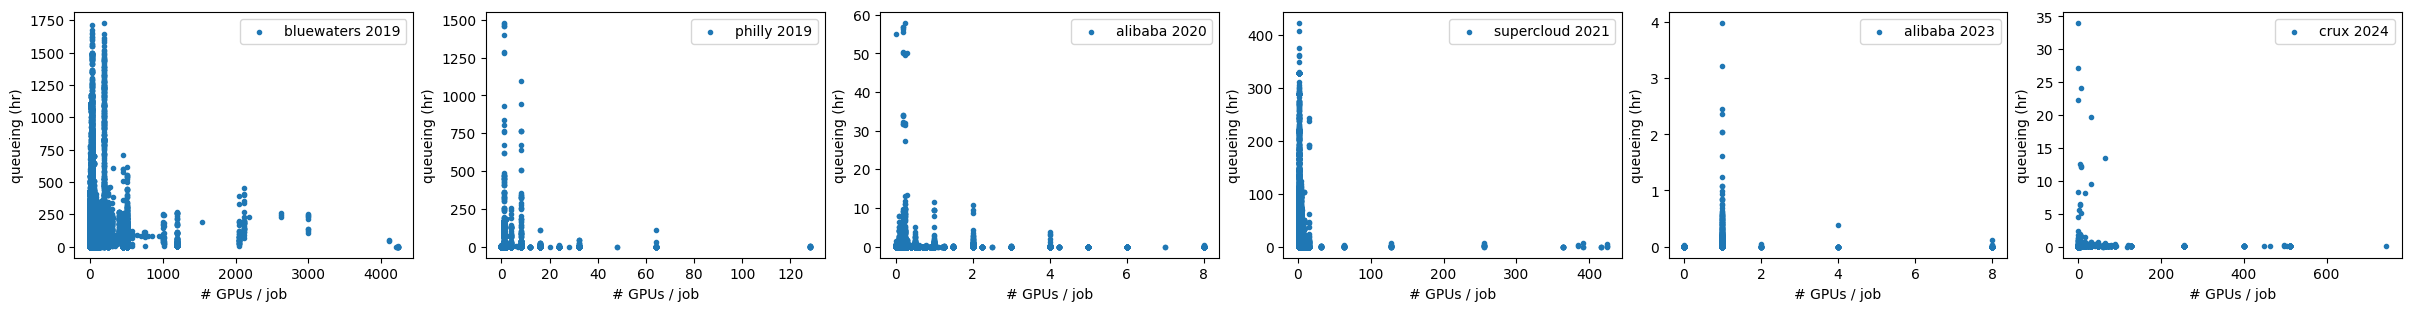

In [27]:
names = ['bluewaters 2019', 'philly 2019', 'alibaba 2020', 'supercloud 2021', 'alibaba 2023', 'crux 2024']

fig, axs = plt.subplots(1, len(names), figsize=(4 * len(names), 3), layout="constrained")
for i, name in enumerate(names):
    ax = axs[i]
    trace = traces[name]
    ax.scatter(trace['gpu'], trace['queueing'] / 3600, label=name, marker='.')
    ax.set_xlabel('# GPUs / job')
    ax.set_ylabel('queueing (hr)')
    ax.legend()

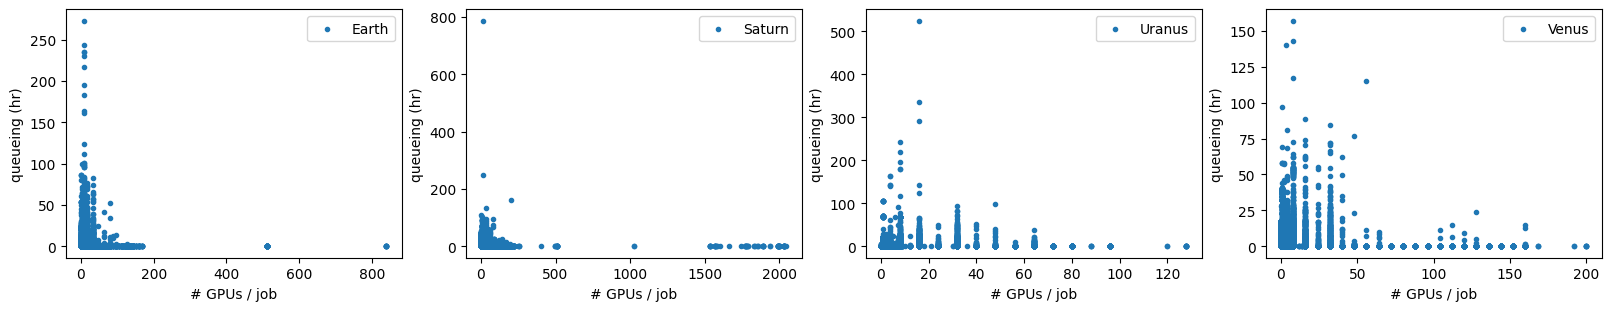

In [22]:
name = 'helios 2021'
trace = traces[name]

fig, axs = plt.subplots(1, 4, figsize=(16, 3), layout="constrained")
for i, cluster in enumerate(['Earth', 'Saturn', 'Uranus', 'Venus']):
    ax = axs[i]
    df = trace[trace['cluster_name'] == cluster]
    ax.scatter(df['gpu'], df['queueing'] / 3600, label=cluster, marker='.')
    ax.set_xlabel('# GPUs / job')
    ax.set_ylabel('queueing (hr)')
    ax.legend()

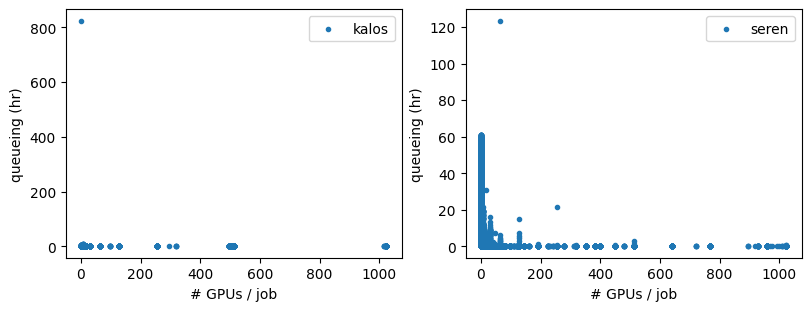

In [23]:
name = 'acme 2024'
trace = traces[name]

fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout="constrained")
for i, cluster in enumerate(['kalos', 'seren']):
    ax = axs[i]
    df = trace[trace['cluster_name'] == cluster]
    ax.scatter(df['gpu'], df['queueing'] / 3600, label=cluster, marker='.')
    ax.set_xlabel('# GPUs / job')
    ax.set_ylabel('queueing (hr)')
    ax.legend()

## Arrival pattern (timeseries)

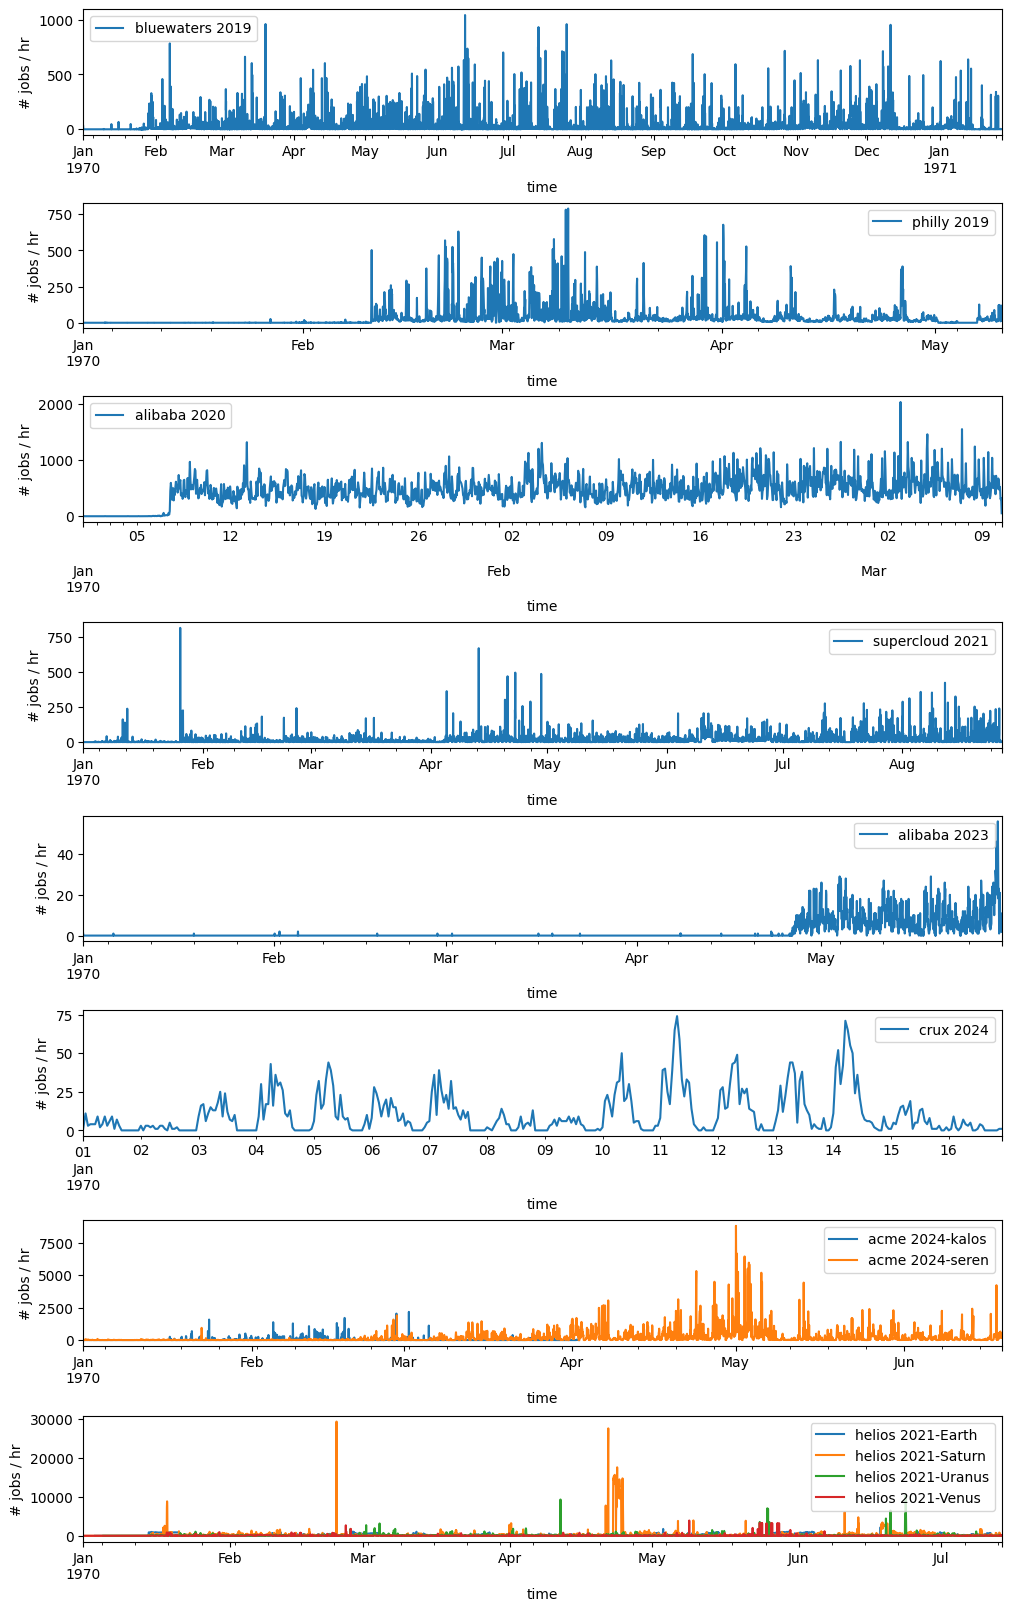

In [28]:
names = ['bluewaters 2019', 'philly 2019', 'alibaba 2020', 'supercloud 2021', 'alibaba 2023', 'crux 2024', 'acme 2024', 'helios 2021']

def sample(trace):
    trace["arrival-dt"] = pd.to_datetime(trace["arrival"], unit="s")
    trace.set_index("arrival-dt", inplace=True)
    jobs_per_hour = trace.resample("h").size()
    return jobs_per_hour

fig, axs = plt.subplots(len(names), 1, figsize=(10, 2 * len(names)), layout="constrained")
for i, name in enumerate(names):
    ax = axs[i]
    if name == 'acme 2024':
        for cluster in ['kalos', 'seren']:
            trace = traces[name]
            jobs_per_hour = sample(trace[trace['cluster_name'] == cluster][["arrival"]])
            jobs_per_hour.plot(kind='line', linestyle='-', ax=ax, label=f"{name}-{cluster}")
    elif name == 'helios 2021':
        for cluster in ['Earth', 'Saturn', 'Uranus', 'Venus']:
            trace = traces[name]
            jobs_per_hour = sample(trace[trace['cluster_name'] == cluster][["arrival"]])
            jobs_per_hour.plot(kind='line', linestyle='-', ax=ax, label=f"{name}-{cluster}")
    else:
        jobs_per_hour = sample(traces[name][["arrival"]])
        jobs_per_hour.plot(kind='line', linestyle='-', ax=ax, label=name)
    ax.set_xlabel('time')
    ax.set_ylabel('# jobs / hr')
    ax.legend()

## GPU * hours

In [25]:
from math import ceil

for key, df in traces.items():
    gpu_hrs = df["gpu"] * df["running"] / 3600
    print(f"{key}: p99 {ceil(gpu_hrs.quantile(.99))}, max {ceil(gpu_hrs.max())}")
    import matplotlib.pyplot as plt

bluewaters 2019: p99 1341, max 98500
philly 2019: p99 726, max 27539
alibaba 2020: p99 21, max 1326
helios 2021: p99 118, max 23793
supercloud 2021: p99 194, max 3841
alibaba 2023: p99 39, max 3483
acme 2024: p99 17, max 126418
crux 2024: p99 1542, max 22007
